# Example 1: FFI Lightcurves of WASP-107 (Sector 10)

In this notebook, we will use a simple aperture photometry to extract the lightcurve of WASP-107 as observed by TESS in Sector 10.

The star was observed by TESS on its Camera 1, CCD 4 in Sector 10 (useful in finding reference star). The FFI cut data was downloaded from [TESSCut](https://mast.stsci.edu/tesscut/).

In the notebook, we will follow the following steps:

1. Background Correction
2. Simple aperture photometry
3. Pixel-level decorrelation to detrend the photometry

Acknowledgements: this notebooks uses much of the code from [https://github.com/nespinoza/PLD-TESS](https://github.com/nespinoza/PLD-TESS).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.table import Table
from astropy.stats import SigmaClip, mad_std

In [2]:
# Loading FFI data
hdul = fits.open('tess-s0010-1-4_188.386850_-10.146174_10x15_astrocut.fits')
tab1 = Table.read(hdul[1])

# Reference BJD time
bjd_ref = hdul[0].header['BJDREFI']

# All columns/data available
tab1.colnames

['TIME',
 'TIMECORR',
 'CADENCENO',
 'RAW_CNTS',
 'FLUX',
 'FLUX_ERR',
 'FLUX_BKG',
 'FLUX_BKG_ERR',
 'QUALITY',
 'POS_CORR1',
 'POS_CORR2',
 'FFI_FILE']

Saving time, 2D flux and 2D flux error in another array:

In [3]:
quality = np.asarray(tab1['QUALITY'])

tim = np.asarray(tab1['TIME'][quality==0])+bjd_ref
fl2d, fle2d = np.asarray(tab1['FLUX'][quality==0]), np.asarray(tab1['FLUX_ERR'][quality==0])

print(fl2d.shape)

(1057, 15, 10)


Okay, so the flux array is 2d time-series of detector image. Let's see how one of the arbitrary time-stamp looks like.

Text(0.5, 1.0, 'Timestamp at BJD = 2458580.1207')

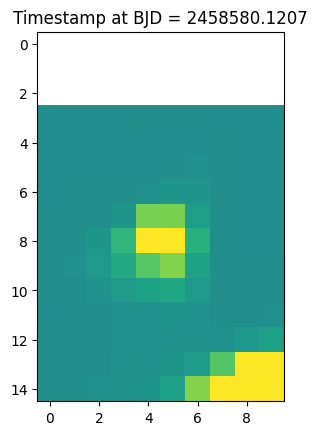

In [4]:
nint = np.random.randint(0,fle2d.shape[0])
im = plt.imshow(fl2d[nint,:,:])
im.set_clim([np.nanmedian(fl2d)-np.nanstd(fl2d), np.nanmedian(fl2d)+np.nanstd(fl2d)])
plt.title('Timestamp at BJD = {:.4f}'.format(tim[nint]))

The target is the one in the middle of the array (and not the one at the edge).

Let's see the median image,

Text(0.5, 1.0, 'Median Image')

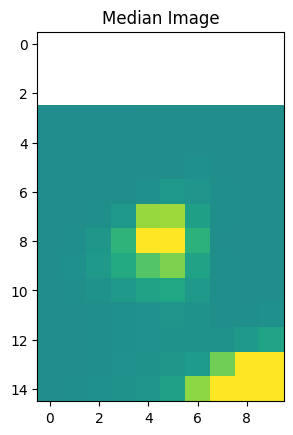

In [5]:
med_img = np.median(fl2d, axis=0)

im = plt.imshow(med_img)
im.set_clim([np.nanmedian(fl2d)-np.nanstd(fl2d), np.nanmedian(fl2d)+np.nanstd(fl2d)])
plt.title('Median Image')

Not so different! We will use this image to generate the aperture. We will do so by simply selecting ~10 brightest pixels from this image, but we need to be careful in not selecting the pixels on the bottom-right of the image.

Text(0.5, 1.0, 'Background Mask')

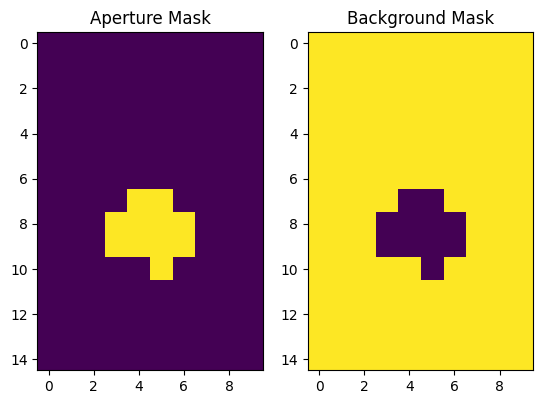

In [6]:
med_img_flat = med_img.flatten()
med_img_sorted = np.sort(med_img_flat)

ap_pix = 10
ap_mask = np.zeros(med_img.shape)
bkg_mask = np.ones(med_img.shape)
ap_corx, ap_cory = np.array([]), np.array([])    # Coordinates of aperute pixels

tot_num = True
ap_pix_nos, i = 0, 0
while tot_num:
    if np.isnan(med_img_sorted[-1-i]):
        i = i + 1
        continue
    else:
        ind = np.where(med_img == med_img_sorted[-1-i])
        # To prevent aperture being far from the center
        if (ind[0][0] > 11) or (ind[0][0] < 2):# or (ind[0][0]):
            i = i + 1
            continue
        else:
            ap_mask[ind[0][0], ind[1][0]] = 1.
            bkg_mask[ind[0][0], ind[1][0]] = 0.
            ap_cory = np.hstack((ap_cory, int(ind[0][0])))     # Because the zeroth index is y pos
            ap_corx = np.hstack((ap_corx, int(ind[1][0])))     # and the first index is x pos
            ap_pix_nos = ap_pix_nos + 1
            if ap_pix_nos>10:
                tot_num = False
            i = i + 1

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(ap_mask)
axs[0].set_title('Aperture Mask')

axs[1].imshow(bkg_mask)
axs[1].set_title('Background Mask')

This looks reasonable! Now, we will perform background subtraction _and_ aperture photometry simultaneously.

In [7]:
xs = np.arange(ap_mask.shape[1])
ys = np.arange(ap_mask.shape[0])

lc1, lc1_err = np.zeros(len(tim)), np.zeros(len(tim))
xpos, ypos = np.zeros(len(tim)), np.zeros(len(tim))
pix_flxs = np.zeros((len(tim), len(ap_corx)))

for i in range(len(tim)):
    # Background subtraction
    tstamp2 = fl2d[i,:,:] - np.nanmedian(fl2d[i,:,:]*bkg_mask, axis=(0,1))
    lc1[i] = np.nansum(tstamp2*ap_mask, axis=(0,1))
    lc1_err[i] = np.sqrt(np.nansum((fle2d[i,:,:] * ap_mask)**2, axis=(0,1)))
    # centroids
    xpos[i] = np.nansum(xs*np.nansum(tstamp2, axis=0))/np.nansum(tstamp2, axis=(0,1))
    ypos[i] = np.nansum(ys*np.nansum(tstamp2, axis=1))/np.nansum(tstamp2, axis=(0,1))
    # Saving flux for each individual pixels
    for j in range(len(ap_corx)):
        pix_flxs[i, j] = tstamp2[int(ap_cory[j]),int(ap_corx[j])]

MAD of the lightcurve is: 4639.5626 ppm


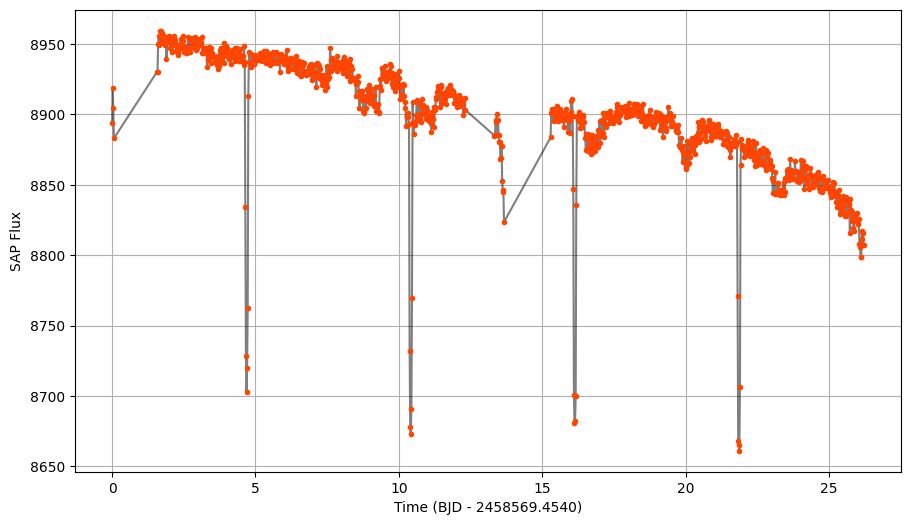

In [8]:
sc = SigmaClip(sigma_upper=20, sigma_lower=20, stdfunc=mad_std, maxiters=None)
msk1 = sc(lc1).mask

print('MAD of the lightcurve is: {:.4f} ppm'.format(mad_std(lc1[~msk1]/np.median(lc1[~msk1]))*1e6))

# Let's see how it looks (please be good)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim[~msk1]-tim[~msk1][0], lc1[~msk1], fmt='.', c='orangered')
plt.plot(tim[~msk1]-tim[~msk1][0], lc1[~msk1], c='k', alpha=0.5)
plt.xlabel('Time (BJD - {:.4f})'.format(tim[~msk1][0]))
plt.ylabel('SAP Flux')
plt.grid()

How does the centroids looks like:

Text(0, 0.5, 'Y positions')

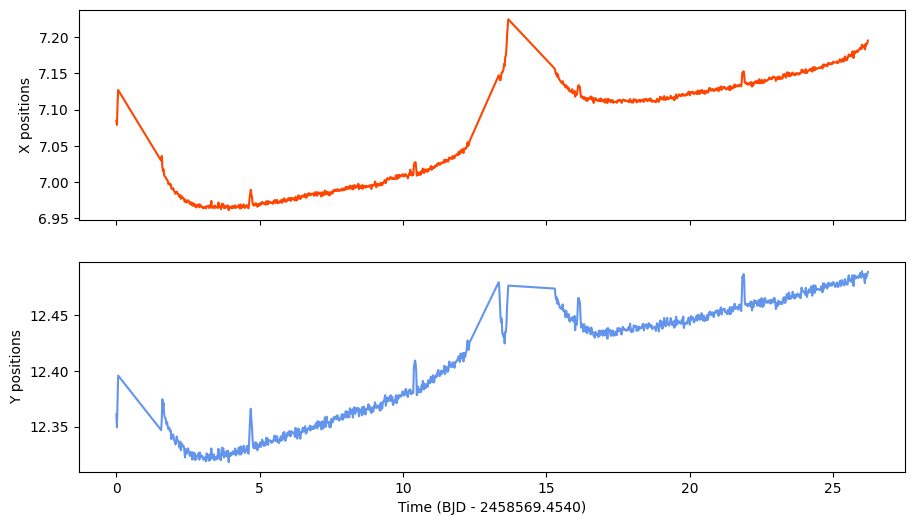

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16/1.5, 9/1.5), sharex=True)

axs[0].plot(tim[~msk1]-tim[~msk1][0], xpos[~msk1], c='orangered')
axs[0].set_ylabel('X positions')

axs[1].plot(tim[~msk1]-tim[~msk1][0], ypos[~msk1], c='cornflowerblue')
axs[1].set_xlabel('Time (BJD - {:.4f})'.format(tim[~msk1][0]))
axs[1].set_ylabel('Y positions')

So, we may want to use centroids to detrend the data in the end. But still, the data is noisy! So, we will use pixel-level detrending to detrend the data.

We have already saved the pixel-level flux in an array (`pix_flxs`) -- first let's visualise how the pixel-level data looks like:

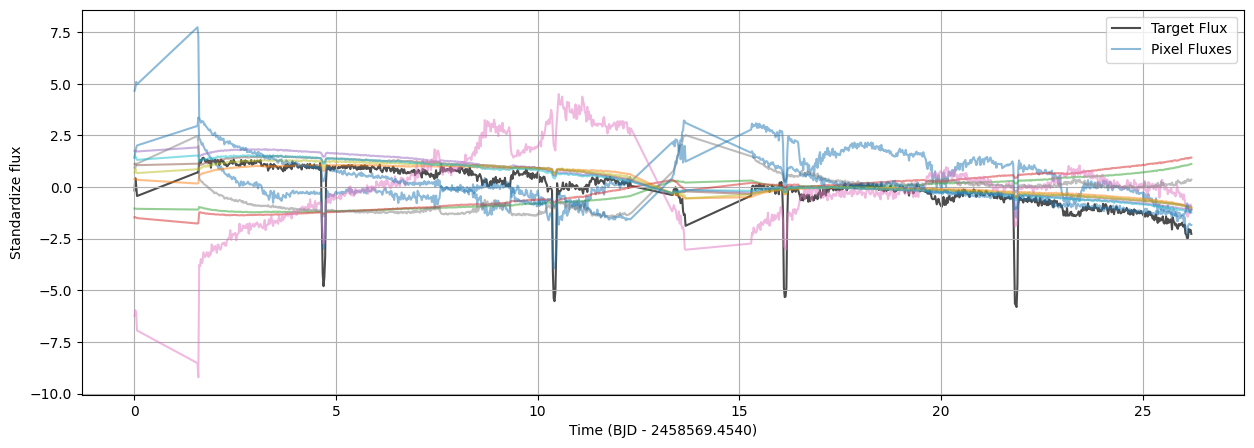

In [10]:
def standard(x):
    return (x-np.median(x))/mad_std(x)

plt.figure(figsize=(15,5))
plt.plot(tim[~msk1]-tim[~msk1][0], standard(lc1[~msk1]), 'k-', label='Target Flux', alpha=0.7, zorder=0)
for i in range(pix_flxs.shape[1]):
    if i == 0:
        plt.plot(tim[~msk1]-tim[~msk1][0], standard(pix_flxs[~msk1,i]), alpha=0.5, label='Pixel Fluxes', zorder=10)
    else:
        plt.plot(tim[~msk1]-tim[~msk1][0], standard(pix_flxs[~msk1,i]), alpha=0.5, zorder=10)
plt.xlabel('Time (BJD - {:.4f})'.format(tim[~msk1][0]))
plt.ylabel('Standardize flux')
plt.legend(loc='best')
plt.grid()

So, the basic idea is to use these pixel fluxes as a linear regressors to detrend the lightcurve. More details can be found in the resources that I mentioned earlier. Essentially, we want to model the total flux as, $F(t) = A + \sum_i a_i \hat{P}_i(t)$, where $\hat{P}_i(t) \equiv P_i(t)/\sum_i P_i(t)$ and $A$ is the out-of-transit flux.

In [11]:
# First defining Phat
Phat = np.zeros(pix_flxs.shape)
Psum = np.nansum(pix_flxs,axis=1)

for i in range(Phat.shape[0]):
    Phat[i,:] = pix_flxs[i,:]/Psum[i]

Now, it is possible to directly use this $\hat{P}$ as decorrelation vectors -- however, we may be overfitting in that case. Because there would be a lot of correlation among those vectors as shown below:

Text(0, 0.5, 'Element $j$')

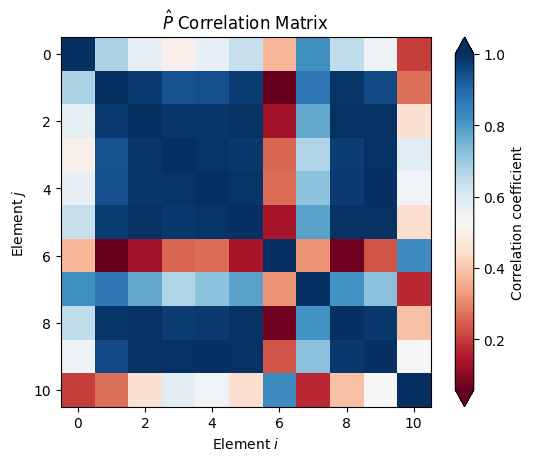

In [12]:
CorrelationMatrix = np.abs(np.corrcoef(Phat.T))
plt.title('$\hat{P}$ Correlation Matrix')
im = plt.imshow(CorrelationMatrix,cmap='RdBu')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

So, we will now perform principal component analysis (PCA) on these vectors and then we will only use first principal components in detrending:

In [13]:
def standarize_data(input_data):
    """
    Standarize the dataset
    """
    output_data = np.copy(input_data)
    averages = np.median(input_data,axis=1)
    for i in range(len(averages)):
        sigma = mad_std(output_data[i,:])
        output_data[i,:] = output_data[i,:] - averages[i]
        output_data[i,:] = output_data[i,:]/sigma
    return output_data

def classic_PCA(Input_Data, standarize = True):
    """  
    classic_PCA function
    Description
    This function performs the classic Principal Component Analysis on a given dataset.
    """
    if standarize:
        Data = standarize_data(Input_Data)
    else:
        Data = np.copy(Input_Data)
    eigenvectors_cols,eigenvalues,eigenvectors_rows = np.linalg.svd(np.cov(Data))
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx[::-1]]
    eigenvectors_cols = eigenvectors_cols[:,idx[::-1]]
    eigenvectors_rows = eigenvectors_rows[idx[::-1],:]
    # Return: V matrix, eigenvalues and the principal components.
    return eigenvectors_rows,eigenvalues,np.dot(eigenvectors_rows,Data)

V, eigenvalues, PCA = classic_PCA(Phat.T)

Let's see if there is correlations in the PCAs:

Text(0, 0.5, 'Element $j$')

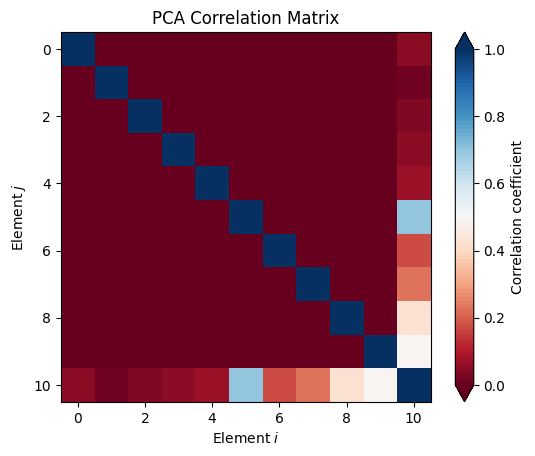

In [14]:
PCACorrelationMatrix = np.abs(np.corrcoef(PCA))
plt.title('PCA Correlation Matrix')
im = plt.imshow(PCACorrelationMatrix,cmap='RdBu')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

Great! We can now use PCs as decorrelation vectors in detrending. But before that, let's have a look at eigenvalues (we want to select only first few vectors):

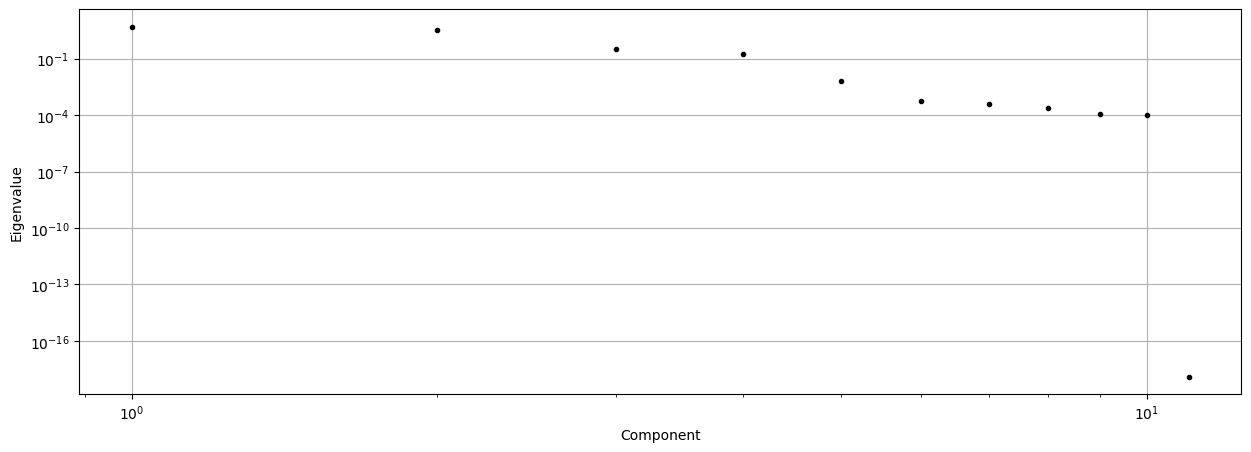

In [15]:
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(len(eigenvalues))+1, eigenvalues, fmt='.', c='k')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-7,np.max(eigenvalues)])
plt.grid()

The eigenvalue curve mostly flattens after first 5 components. So, in the following analysis, we will just use first 5 components.

Let's first analytically compute the PLD prediction model before doing a more thorough analysis.

In [16]:
X = np.vstack(( np.ones(len(lc1)), PCA[:5,:] ))
# Fit:
result = np.linalg.lstsq(X.T, lc1, rcond=None)
coeffs = result[0]

prediction = np.dot(coeffs, X)

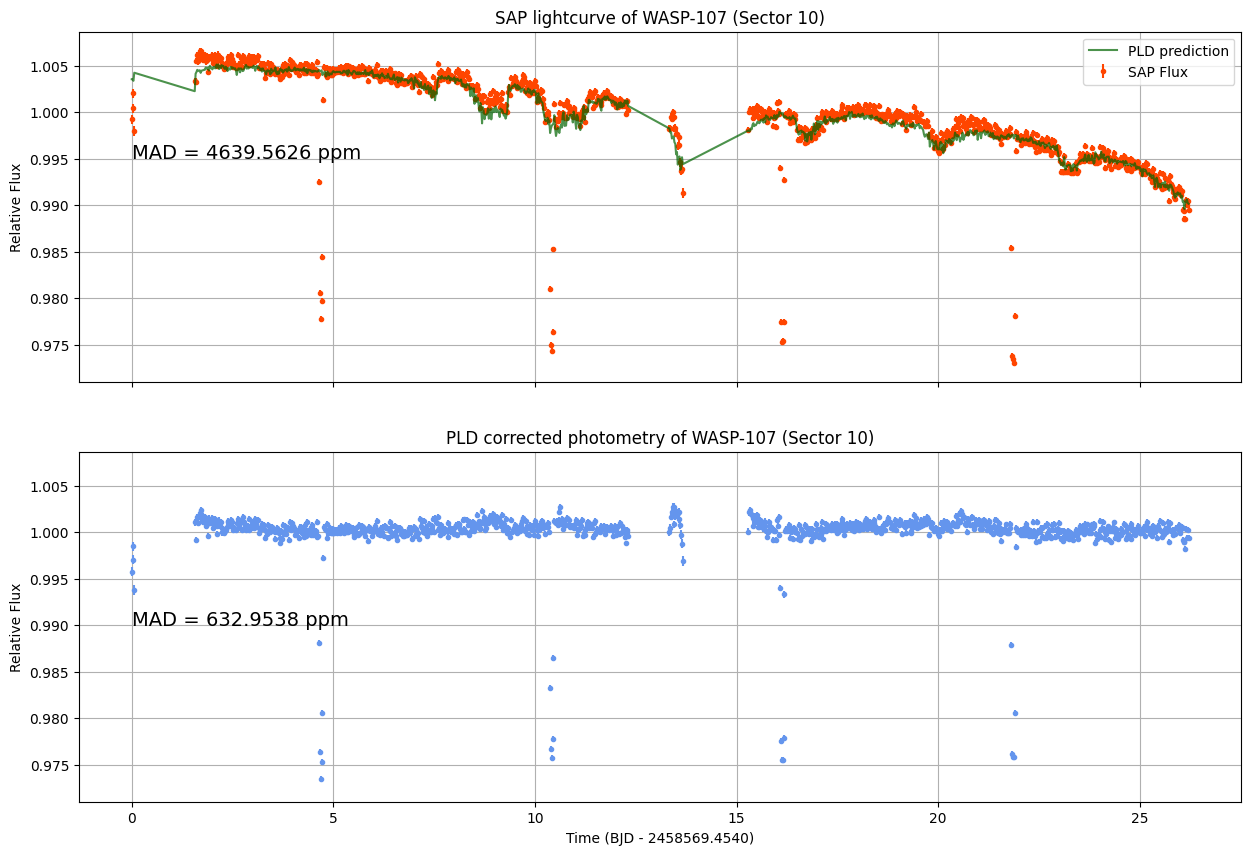

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharex=True, sharey=True)

axs[0].errorbar(tim-tim[0], lc1/np.median(lc1), yerr=lc1_err/np.median(lc1), fmt='.', c='orangered', label='SAP Flux')
axs[0].plot(tim-tim[0], prediction/np.median(lc1), c='darkgreen', label='PLD prediction',alpha=0.7, zorder=10)
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('SAP lightcurve of WASP-107 (Sector 10)')
axs[0].text(0., 0.995, 'MAD = {:.4f} ppm'.format(mad_std(lc1/np.median(lc1))*1e6), fontsize=14)
axs[0].legend(loc='best')
axs[0].grid()

axs[1].errorbar(tim-tim[0], lc1/prediction, yerr=lc1_err/prediction, fmt='.', c='cornflowerblue')
axs[1].set_xlabel('Time (BJD - {:.4f})'.format(tim[0]))
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('PLD corrected photometry of WASP-107 (Sector 10)')
axs[1].text(0., 0.990, 'MAD = {:.4f} ppm'.format(mad_std(lc1/prediction)*1e6), fontsize=14)
axs[1].grid()

In [18]:
# Saving SAP
sap_lc, sap_lce = lc1/np.median(lc1), lc1_err/np.median(lc1)
fsap = open('simple_aperture_photometry.dat', 'w')
fsap.write('# Time (BJD)\t\tRelative flux\tRelative flux err')
for i in range(len(sap_lc)):
    fsap.write(str(tim[i]) + '\t' + str(sap_lc[i]) + '\t' + str(sap_lce[i]) + '\n')
fsap.close()

# Saving PCs
np.save('PCs.npy', PCA)

# Saving PLD-Corrected LCs
pld_lc, pld_lce = lc1/prediction, lc1_err/prediction
fpld = open('pld_corrected_photometry.dat', 'w')
fpld.write('# Time (BJD)\t\tRelative flux\tRelative flux err')
for i in range(len(pld_lc)):
    fpld.write(str(tim[i]) + '\t' + str(pld_lc[i]) + '\t' + str(pld_lce[i]) + '\n')
fpld.close

<function TextIOWrapper.close()>